Librerías necesarias:

In [2]:
import numpy as np 
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import csv
#from scipy import stats
#KERAS
import h5py
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from sklearn.metrics import classification_report
import collections
#np.set_printoptions(threshold=np.inf)
from keras.models import model_from_json
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.backend as K
from PIL import Image
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3

Leemos el directorio y contamos cuántas imágenes hay

In [8]:
directoris = []
contador = []
fitxers = []
path_img = []

# Retorna el path a les fotos (path), el nom de les fotos (fitxers) i la quantitat (contador)
for dirname, _, filenames in os.walk('/Volumes/Lorena/APTOS/aptos2019-blindness-detection/train_images',followlinks=False):
    #print(dirs)
    #filenames.remove(".DS_Store")
    #print(dirname)
    directoris.append(os.path.join(dirname))
    for i in filenames:
        if not '._' in i:
            fitxers.append(i)
            path_img.append(dirname+"/"+i)
    contador.append(dirname+': CONTÉ '+str(len(fitxers)) + ' FOTOS')

In [9]:
# Cargamos el train.csv
csv_train = open('/Volumes/Lorena/APTOS/aptos2019-blindness-detection/train.csv')
csvreader = csv.reader(csv_train)
rows = []
for row in csvreader:
        rows.append(row)

Creamos los sets de imágens y etiquetas

In [10]:
data = []
labels = []
# recorremos los paths de las imágenes y de las filas del csv, buscamos el nombre de la imágen en el
#csv y creamos dos sets de datos con las imágenes y la etiqueta correspondiente en la misma posición
for imagePath in path_img:
    #print(imagePath)
    if not '._' in imagePath:
        for row in rows:
            item = imagePath.split(os.path.sep)[-1]
            if item[0:item.find('.')] in row[0] and item[1]!='_' :
                # leemos la imagen
                image = cv2.imread(imagePath)
                image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_LINEAR)
                # creamos los arrays de imágenes y etiquetas
                data.append(image)
                labels.append(row[0][(row[0].find(';'))+1:])

In [11]:
#Función que recorta los bordes de las imágenes 
#(inspirado en  https://www.kaggle.com/ratthachat/aptos-updated-preprocessing-ben-s-cropping)
def crop_border(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = gray_img > 7       
    check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
    if (check_shape == 0):
        return img
    else:
        img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
        img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
        img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
        img = np.stack([img1,img2,img3],axis=-1)
    return img

In [12]:
processed_data = []

for img in data:
    image = img
    image = crop_border(image)
            
    image = cv2.resize(image, (256, 256))
    
    # Applying GaussianBlur
    blurred = cv2.blur(image, ksize=(int(256 / 6), int(256 / 6)))
    image_blur = cv2.addWeighted(image, 4, cv2.GaussianBlur( image , (0,0) , 10) ,-4 ,128)
    
    processed_data.append(image_blur)

In [13]:
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))


{'0': 1796, '1': 369, '2': 995, '3': 193, '4': 295}

In [14]:
minimo=min(counts)
print("Minimo support: ", minimo) #cogemos el minimo para equiparar la data de cada label

Minimo support:  193


In [15]:
fondo=0; necrotico=0; granulado=0; piel=0; esfacelo=0
indices_c=[]; indices_u=[]; indices_d=[]; indices_t=[]; indices_q=[]


In [16]:
lab_0=0; lab_1=0; lab_2=0; lab_3=0; lab_4=0
ind_0=[]; ind_1=[]; ind_2=[]; ind_3=[]; ind_4=[]

for a in range(len(labels)): #hacemos cinco listas de los indices de cada label de longitud=minimo
    if (labels[a]=='0' and lab_0<minimo):
        lab_0+=1
        ind_0.append(a)
    if (labels[a]=='1' and lab_1<minimo):
        lab_1+=1
        ind_1.append(a)
    if (labels[a]=='2' and lab_2<minimo):
        lab_2+=1
        ind_2.append(a)
    if (labels[a]=='3' and lab_3<minimo):
        lab_3+=1
        ind_3.append(a)
    if (labels[a]=='4' and lab_4<minimo):
        lab_4+=1
        ind_4.append(a)

In [17]:
#Passem les dades a array
data_arr = np.array(processed_data)
labels_arr = np.array(labels)

final = int(minimo*0.8)

#se separa la data en train y test
ind_Train = ind_0[:final] + ind_1[:final] + ind_2[:final] + ind_3[:final] + ind_4[:final] 
ind_Test =  ind_0[final:] + ind_1[final:] + ind_2[final:] + ind_3[final:] + ind_4[final:]

print("Lista train:", len(ind_Train)," test: ", len(ind_Test),"\nTotal lista: ", len(ind_Train)+len(ind_Test), " minimo total:", minimo*5)

Train = ind_Train + ind_Test

Train_Data = data_arr[Train, :, :, :] #All data (train + test)
Train_Labels = to_categorical(np.array(labels_arr[Train])) #All labels (train + test)

indTrainP = np.random.permutation(ind_Train)
indTestP = np.random.permutation(ind_Test) 
 
       
train_data = data_arr[indTrainP, :, :, :] #Data with 80% of data (train)
print(type(train_data))
print(np.shape(train_data))
train_labels = to_categorical(np.array(labels_arr[indTrainP])) 
print(type(train_labels))
print(np.shape(train_labels))
test_data = data_arr[indTestP, :, :, :] #Data with 20%of data (test)
test_labels = to_categorical(np.array(labels_arr[indTestP])) #test labels from labels (x, 4) because it's encoded
print("Shape of labels", train_labels.shape, "shape of data train", train_data.shape, "shape of test train", test_data.shape)

Lista train: 770  test:  195 
Total lista:  965  minimo total: 965
<class 'numpy.ndarray'>
(770, 256, 256, 3)
<class 'numpy.ndarray'>
(770, 5)
Shape of labels (770, 5) shape of data train (770, 256, 256, 3) shape of test train (195, 256, 256, 3)


In [18]:
#PARA COMPROBAR QUE EL NUMERO ES EL MISMO
counterT=collections.Counter(np.argmax(test_labels,axis=1))
print("counter test", counterT)

counterTR=collections.Counter(np.argmax(train_labels,axis=1))
print("counter train", counterTR)

counter test Counter({1: 39, 2: 39, 0: 39, 4: 39, 3: 39})
counter train Counter({3: 154, 4: 154, 0: 154, 2: 154, 1: 154})


In [19]:
# Model en xarxa preentrenada
#base_model = InceptionV3(input_shape = (256, 256, 3), include_top = False, weights = 'imagenet')
base_model = VGG16(input_shape = (256, 256, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(5, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

#model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

2022-05-03 23:33:24.817486: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
#Obtenemos el conjunto de validación con un 10% del de entrenamiento
t_x, val_x, t_y, val_y = train_test_split(train_data, train_labels, test_size=0.1, 
                                           random_state = np.random.randint(1,1000, 1)[0])

def modelLrOpt(opt, lrate):
    acc = []
    t = [] 
    #set early stopping criteria
    pat = 5 #this is the number of epochs with no improvment after which the training will stop
    early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)
    #define the model checkpoint callback -> this will keep on saving the model as a physical file
    #model_checkpoint = ModelCheckpoint('Model_VGG16.h5', verbose=1, save_best_only=True)
    for lr in lrate:
        model.compile(loss='categorical_crossentropy', optimizer=opt(lr=lr), metrics=['accuracy'])
        start_time = timeit.default_timer()
        history = model.fit(t_x, t_y,validation_data=(val_x, val_y),epochs=20, batch_size=100, verbose=1, 
                            callbacks=[early_stopping])
        t.append(timeit.default_timer() - start_time)
        acc.append(model.evaluate(test_data, test_labels, verbose=0)[1])

    return history, model, t, acc

In [27]:
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad
import timeit
lr = [0.001,0.01,0.05,0.1]
print("Training Adam models...")
histAdam, modAdam, tAdam, accAdam = modelLrOpt(Adam, lr)
print("Training SGD models...")
histSGD, modSGD, tSGD, accSGD = modelLrOpt(SGD, lr)
print("Training Adadelta models...")
histAdadelta, modAdadelta, tAdadelta, accAdadelta = modelLrOpt(Adadelta, lr)
print("Training Adagrad models...")
histAdagrad, modAdagrad, tAdagrad, accAdagrad = modelLrOpt(Adagrad, lr)

Training Adam models...
Epoch 1/20
7/7 [==============================] - 105s 15s/step - loss: 2.1358 - accuracy: 0.8066 - val_loss: 0.9525 - val_accuracy: 0.8961
Epoch 2/20
7/7 [==============================] - 108s 16s/step - loss: 2.3227 - accuracy: 0.8081 - val_loss: 0.4433 - val_accuracy: 0.8961
Epoch 3/20
7/7 [==============================] - 115s 17s/step - loss: 1.4890 - accuracy: 0.8268 - val_loss: 1.4846 - val_accuracy: 0.7922
Epoch 4/20
7/7 [==============================] - 121s 18s/step - loss: 0.7674 - accuracy: 0.8499 - val_loss: 0.6405 - val_accuracy: 0.8312
Epoch 5/20
7/7 [==============================] - 117s 17s/step - loss: 0.8962 - accuracy: 0.8456 - val_loss: 0.5356 - val_accuracy: 0.8312
Epoch 6/20
7/7 [==============================] - 116s 17s/step - loss: 0.6305 - accuracy: 0.8658 - val_loss: 0.5268 - val_accuracy: 0.8571
Epoch 7/20
7/7 [==============================] - 118s 17s/step - loss: 0.5770 - accuracy: 0.8571 - val_loss: 0.4757 - val_accuracy: 0.8

7/7 [==============================] - 120s 18s/step - loss: 1.5839 - accuracy: 0.2165 - val_loss: 1.5320 - val_accuracy: 0.2468
Epoch 9/20
7/7 [==============================] - 119s 17s/step - loss: 1.5792 - accuracy: 0.2193 - val_loss: 1.5320 - val_accuracy: 0.2468
Epoch 10/20
7/7 [==============================] - 127s 18s/step - loss: 1.5863 - accuracy: 0.2165 - val_loss: 1.5320 - val_accuracy: 0.2468
Epoch 11/20
7/7 [==============================] - 120s 17s/step - loss: 1.5865 - accuracy: 0.2150 - val_loss: 1.5320 - val_accuracy: 0.2468
Epoch 12/20
7/7 [==============================] - 121s 18s/step - loss: 1.5861 - accuracy: 0.2150 - val_loss: 1.5320 - val_accuracy: 0.2468
Epoch 13/20
7/7 [==============================] - 121s 18s/step - loss: 1.5863 - accuracy: 0.2150 - val_loss: 1.5320 - val_accuracy: 0.2468
Epoch 14/20
7/7 [==============================] - 122s 18s/step - loss: 1.5818 - accuracy: 0.2165 - val_loss: 1.5320 - val_accuracy: 0.2468
Epoch 15/20
7/7 [=========

7/7 [==============================] - 114s 17s/step - loss: 1.5847 - accuracy: 0.1919 - val_loss: 1.5293 - val_accuracy: 0.2078
Epoch 7/20
7/7 [==============================] - 122s 17s/step - loss: 1.6091 - accuracy: 0.2165 - val_loss: 1.5292 - val_accuracy: 0.2078
Epoch 8/20
7/7 [==============================] - 114s 17s/step - loss: 1.5887 - accuracy: 0.1934 - val_loss: 1.5291 - val_accuracy: 0.2078
Epoch 9/20
7/7 [==============================] - 114s 16s/step - loss: 1.5886 - accuracy: 0.2063 - val_loss: 1.5290 - val_accuracy: 0.2078
Epoch 10/20
7/7 [==============================] - 113s 16s/step - loss: 1.5886 - accuracy: 0.2063 - val_loss: 1.5289 - val_accuracy: 0.2078
Epoch 11/20
7/7 [==============================] - 113s 16s/step - loss: 1.5865 - accuracy: 0.1876 - val_loss: 1.5290 - val_accuracy: 0.2078
Epoch 12/20
7/7 [==============================] - 114s 16s/step - loss: 1.5745 - accuracy: 0.2193 - val_loss: 1.5290 - val_accuracy: 0.2078
Epoch 13/20
7/7 [===========

7/7 [==============================] - 143s 21s/step - loss: 1.5813 - accuracy: 0.2179 - val_loss: 1.5290 - val_accuracy: 0.2468
Epoch 14/20
7/7 [==============================] - 118s 17s/step - loss: 1.5836 - accuracy: 0.2165 - val_loss: 1.5290 - val_accuracy: 0.2468
Epoch 15/20
7/7 [==============================] - 114s 17s/step - loss: 1.5884 - accuracy: 0.2121 - val_loss: 1.5290 - val_accuracy: 0.2468
Epoch 16/20
7/7 [==============================] - 113s 16s/step - loss: 1.5884 - accuracy: 0.2136 - val_loss: 1.5290 - val_accuracy: 0.2468
Epoch 17/20
7/7 [==============================] - 113s 16s/step - loss: 1.5790 - accuracy: 0.2179 - val_loss: 1.5290 - val_accuracy: 0.2468
Epoch 18/20
7/7 [==============================] - 114s 16s/step - loss: 1.5837 - accuracy: 0.1905 - val_loss: 1.5290 - val_accuracy: 0.2468
Epoch 00018: early stopping
Training Adagrad models...
Epoch 1/20
7/7 [==============================] - 122s 18s/step - loss: 1.5837 - accuracy: 0.2165 - val_loss: 1

7/7 [==============================] - 159s 23s/step - loss: 1.5845 - accuracy: 0.2063 - val_loss: 1.5285 - val_accuracy: 0.2468
Epoch 00006: early stopping


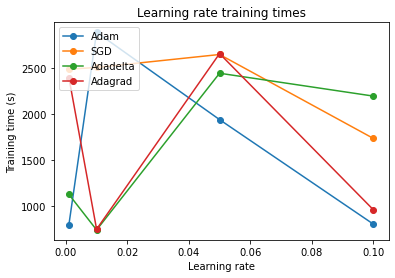

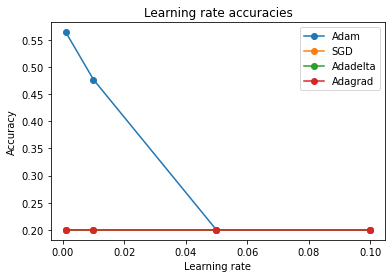

In [29]:
lr = [0.001, 0.01, 0.05, 0.1]
plt.plot(lr, tAdam, marker="o")
plt.plot(lr, tSGD, marker="o")
plt.plot(lr, tAdadelta, marker="o")
plt.plot(lr, tAdagrad, marker="o")
plt.title('Learning rate training times')
plt.ylabel('Training time (s)')
plt.xlabel('Learning rate')
plt.legend(['Adam', 'SGD', 'Adadelta', 'Adagrad'], loc='upper left')
plt.show()


lr = [0.001, 0.01, 0.05, 0.1]
plt.plot(lr, accAdam, marker="o")
plt.plot(lr, accSGD, marker="o")
plt.plot(lr, accAdadelta, marker="o")
plt.plot(lr, accAdagrad, marker="o")
plt.title('Learning rate accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Learning rate')
plt.legend(['Adam', 'SGD', 'Adadelta', 'Adagrad'], loc='upper right')
plt.show()